## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt


ann_arr = load_model('Arrival_time/Arrival_ANN_model_3.h5')
ann_end = load_model('End_time/End_ANN_model_8.h5')
ann_chg = load_model('Change_time/Change_ANN_model_3.h5')

#Section1
ann1 = load_model('Pressure_profiles_codes_section_1_regression/ANN_13.h5')
sc1 = pickle.load(open('Pressure_profiles_codes_section_1_regression/scaler_ANN.pkl', 'rb'))
#Section2
ann2 = load_model('Pressure_profiles_codes_section_2_regression/ANN_1.h5')
sc2 = pickle.load(open('Pressure_profiles_codes_section_2_regression/scaler_ANN.pkl', 'rb'))
#Section3
ann3 = load_model('Pressure_profiles_codes_section_3_regression/ANN_1.h5')
sc3 = pickle.load(open('Pressure_profiles_codes_section_3_regression/scaler_ANN.pkl', 'rb'))
#Section4
ann4 = load_model('Pressure_profiles_codes_section_4_regression/ANN_1.h5')
sc4 = pickle.load(open('Pressure_profiles_codes_section_4_regression/scaler_ANN.pkl', 'rb'))
#Section5
ann5 = load_model('Pressure_profiles_codes_section_5_regression/ANN_1.h5')
sc5 = pickle.load(open('Pressure_profiles_codes_section_5_regression/scaler_ANN.pkl', 'rb'))

D:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
import sklearn
print (sklearn.__version__)

1.2.2


## Input details

In [23]:
charge_mass = 13.8
standoff_distance = 9.2
termination_time = 0.06
interval = 0.00001
atm_pressure = 101200

## Pressure Profile

In [24]:
arr = np.array ([[charge_mass,standoff_distance]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)
    print ("t", t.shape)

    p = np.repeat(atm_pressure, len(t)).reshape(len(t),1)
    print ("p", p.shape)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 3 <= standoff_distance <= 7:
        d_set[:,0:3] = sc1.transform(d_set[:,0:3])
        p_f = ann1.predict(d_set)
        print ("Section 1")
    elif 7 < standoff_distance <= 13:
        d_set[:,0:3] = sc2.transform(d_set[:,0:3])
        p_f = ann2.predict(d_set)
        print ("Section 2")
    elif 13 < standoff_distance <= 19:
        d_set[:,0:3] = sc3.transform(d_set[:,0:3])
        p_f = ann3.predict(d_set)
        print ("Section 3")
    elif 19 < standoff_distance <= 25:
        d_set[:,0:3] = sc4.transform(d_set[:,0:3])
        p_f = ann4.predict(d_set)
        print ("Section 4")
    elif 25 < standoff_distance <= 30:
        d_set[:,0:3] = sc5.transform(d_set[:,0:3])
        p_f = ann5.predict(d_set)
        print ("Section 5")
    else:
        print ("Out of trained range")
    return p_f

if termination_time < arrival_time:
    start = 0
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0
else:
    start = 0
    end = arrival_time
    values1 = stable_state(start, end, interval)
    if termination_time < end_time:
        end_time = termination_time
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)
        
t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(charge_mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(standoff_distance, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)

p2 = p_fluctuation(standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)

if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1

1/1 [==============================] - 0s 23ms/step
t (1533, 1)
p (1533, 1)
t (953, 1)
p (953, 1)
110/110 [==============================] - 0s 1ms/step
Section 2


In [26]:
lsdyna = pd.read_excel('Numerical_results/LSDYNA/13.8kg/9.2m.xlsx')
X2 = lsdyna['Time']
y2 = lsdyna['Pressure']

#viper = pd.read_excel('Numerical_results/Viper/20kg/Viper_6.3m.xlsx')
#X3 = viper['Time']
#y3 = viper['Pressure']

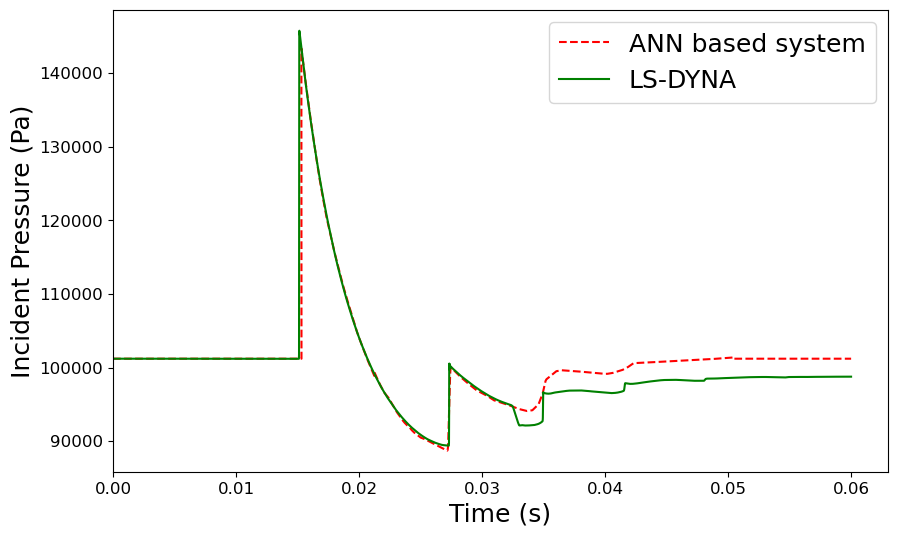

In [27]:
X1 = ml_model[:,0]
y1 = ml_model[:,1]

plt.figure(figsize=(10,6))
plt.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN based system')
plt.plot(X2, y2, color = 'green',label = 'LS-DYNA')
#plt.plot(X3, y3, linestyle = 'dotted', color = 'blue',label = 'Viper Blast')
plt.ylabel('Incident Pressure (Pa)',fontsize = 18)
plt.xlabel('Time (s)',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 18)
plt.xlim (0,)
plt.show()